In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import warnings
warnings.filterwarnings('ignore')
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import statsmodels.tsa.api as smt
import pmdarima as pm
from pylab import rcParams
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.model_selection import ForecastingGridSearchCV, temporal_train_test_split
from sktime.forecasting.compose import ReducedRegressionForecaster
from sktime.utils.plotting.forecasting import plot_ys
from sktime.performance_metrics.forecasting import smape_loss, mase_loss

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

rcParams['figure.figsize'] = 20, 10

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/adscsv/ads.csv
/kaggle/input/adscsv/currency.csv


### Objectives

The goal of this notebook is to use various time series techniques to forecast future sales of an ecommerce product. Throughout the way we will exploring various mathematics of each model, and weigh their pros and cons. 

**Models to explore:**
- Moving Average Model
- Autoregressive Model
- Autoregressive Moving Average (ARMA) Model
- Seasonal Autoregressive Integrated Moving Average (SARIMAX) Model
- Generalised Autoregressive Conditionally Heterskedastic (GARCH) Model
- Gradient Boosted Trees
- Other Libraries: FB Prophet, SKTime

**Concepts to cover:**
- Stationarity (Dicky-Fuller Test)
- Autocorrelation (ACF, PACF)
- Model Diagnostics - Ljung-Box, 
- TS Feature Generation
- Handling Seasonality
- Differencing and Reconstruction
- Rolling Cross Validation
- Evaluation Metrics
- Box-Jenkins Model Selection Framework (Akaike Information Criterion)


TO DO:
- Need auto_arima seems to give worse performance!? --> should find a way to improve this
- Analyse seasonality and input params into SARIMAX
- Need to tune several things like period size 
- Boosted Models using TS Feature Engineering + Rolling CV
- GARCH is a whole other topic for another day

Box-Jenkins Method
- Is time series stationary? If not, try 1st order differencing or transforms.
- Is time series seasonal? If yes, find period and do seasonal differencing / transforms
- Loop through multiple values of p and q to get the best value
- Model Diagnostic - Are residuals uncorrelated and normally distributed? If not, try new p,d,q params

In [7]:

def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

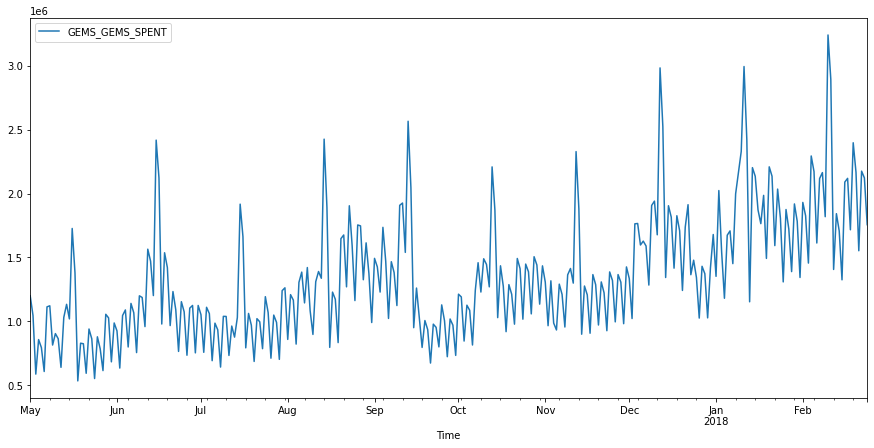

In [8]:
spend = pd.read_csv('/kaggle/input/adscsv/currency.csv', index_col=['Time'], parse_dates=['Time'])
spend.plot(figsize=(15, 7)) # Daily In-game currency spent

In [9]:
def compute_stationarity(df):
    results = adfuller(df)
    print('test statistic: {}'.format(results[0])) # --> negative means possibly stationary
    print('p-value: {}'.format(results[1])) # --> p-value > 0.05, indicates stationary
    print('crtical values: {}'.format(results[4])) 

In [10]:
# test statistic is negative and p-value > 0.05 which implies likely stationary
compute_stationarity(spend)

test statistic: -1.8160113962891058
p-value: 0.3725419518945776
crtical values: {'1%': -3.4535050041524245, '5%': -2.8717352599720294, '10%': -2.5722024776854417}


In [11]:
# but we can make it even more stationary by computing its 1st order diff, d=1
spend_diff = spend.diff().dropna()
compute_stationarity(spend_diff)

test statistic: -6.007482880105362
p-value: 1.6026136773022492e-07
crtical values: {'1%': -3.4537536300652, '5%': -2.8718443180148836, '10%': -2.572260641818822}


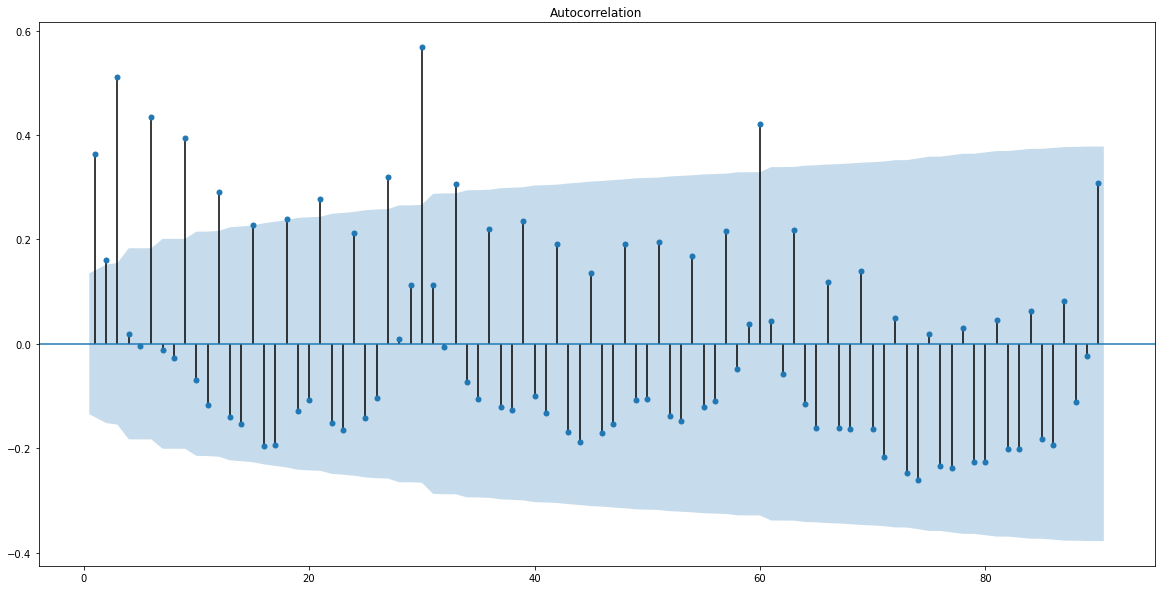

In [12]:
# detrending the data, we see very obviously using ACF that there is a seasonal cycle happening every 30 days

spend2 = spend - spend.rolling(90).mean()
spend2 = spend2.dropna()
plot_acf(spend2, lags=90, zero=False)
plt.show()

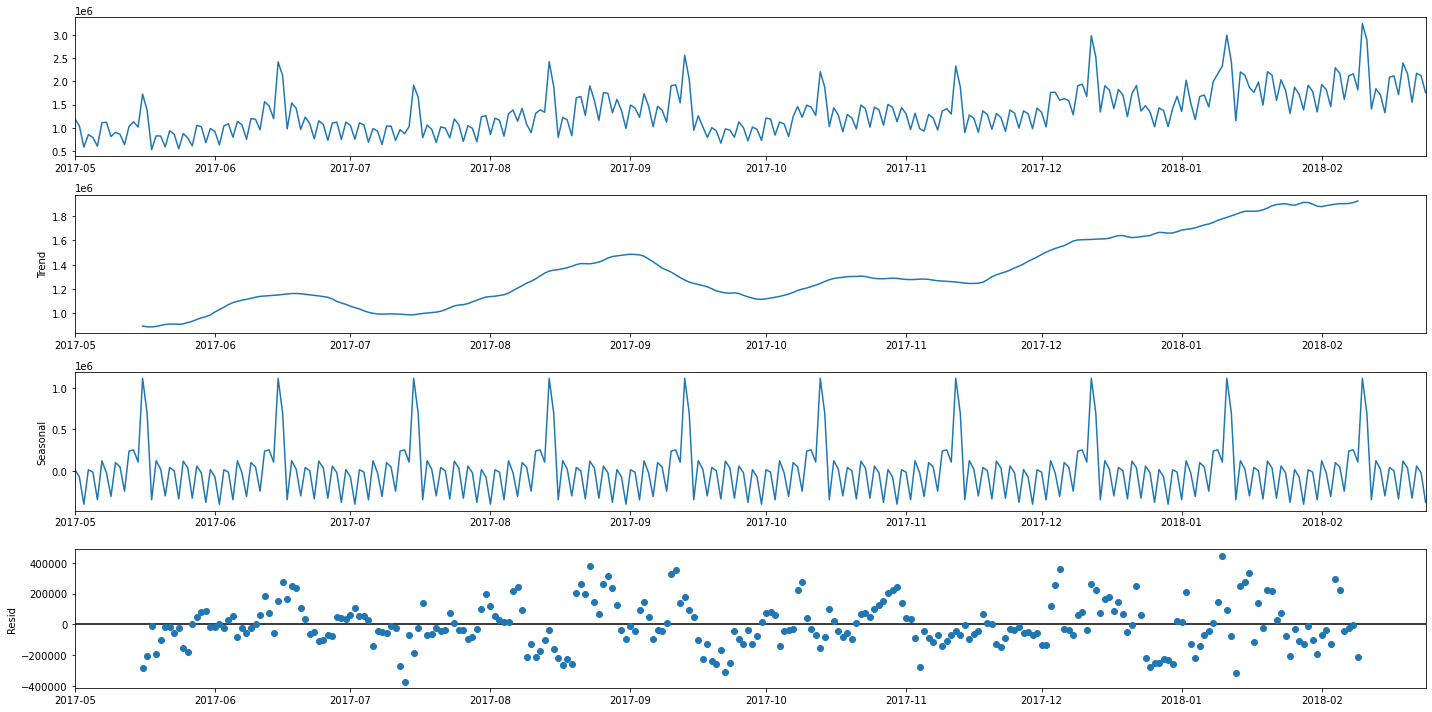

In [13]:
# decomposing TS into trend, seasonality and residuals, we see indeed there is strong seasonality and trend
seasonal_decompose(spend, period=30).plot()
plt.show()

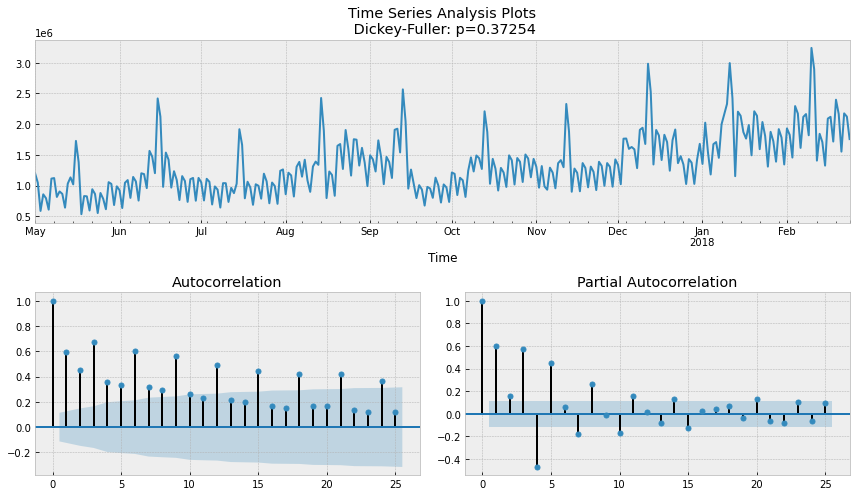

In [14]:
# compute ACF over the detrended data for < 1 period, we see that both ACF an PACF tail off into within the range
# hence likely to be an ARMA(p, q) model, but since d=1, we have an ARIMA(p, d, q) model
tsplot(spend.GEMS_GEMS_SPENT)

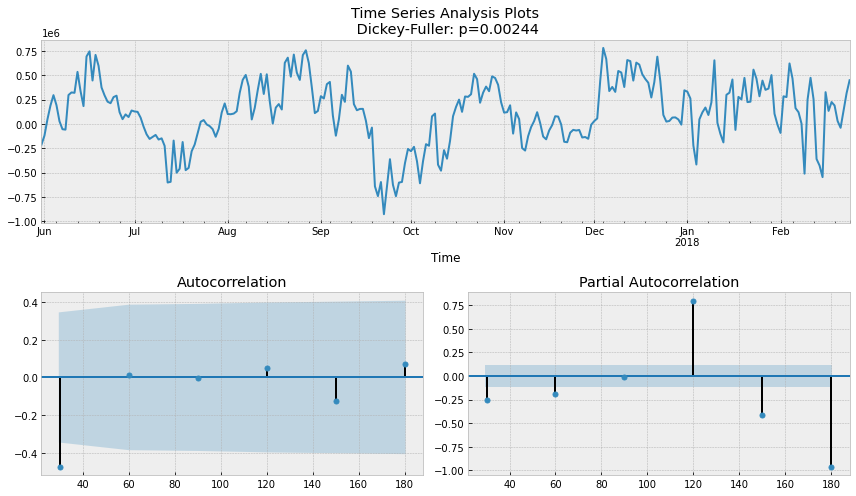

In [15]:
spend_seasonal_diff = spend.diff(30).dropna()
tsplot(spend_seasonal_diff.GEMS_GEMS_SPENT, lags=[30, 60, 90, 120, 150, 180])

                               SARIMAX Results                                
Dep. Variable:        GEMS_GEMS_SPENT   No. Observations:                  300
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -4253.109
Date:                Tue, 08 Sep 2020   AIC                           8514.218
Time:                        13:00:04   BIC                           8529.020
Sample:                    05-01-2017   HQIC                          8520.142
                         - 02-24-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4235.4367   3113.061      1.361      0.174   -1866.051    1.03e+04
ar.L1          0.2347      0.100      2.358      0.018       0.040       0.430
ma.L1         -0.8928      0.045    -19.749      0.0

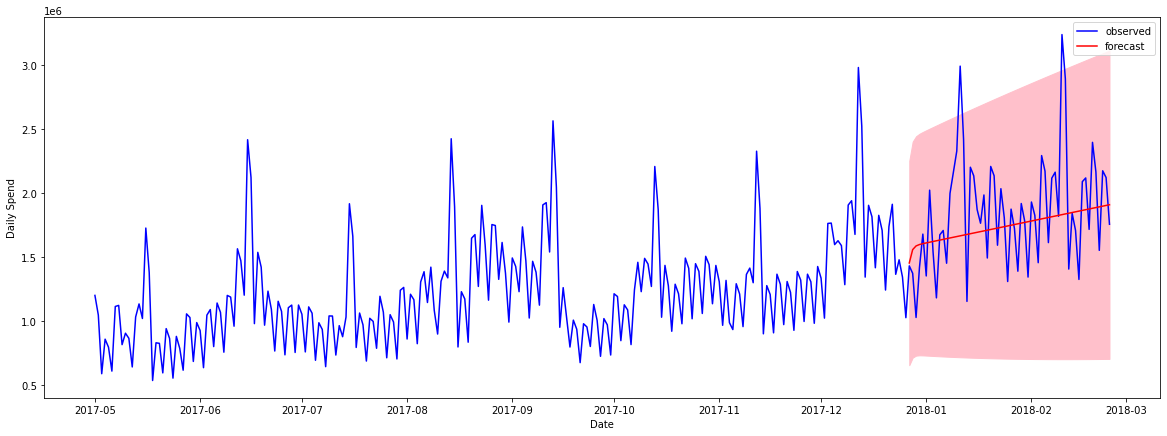

In [18]:
sarimax_forecast(spend, (1,1,1), 'c', -60, dynamic=True)

                               SARIMAX Results                                
Dep. Variable:        GEMS_GEMS_SPENT   No. Observations:                  300
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -4272.684
Date:                Tue, 08 Sep 2020   AIC                           8553.368
Time:                        13:00:05   BIC                           8568.183
Sample:                    05-01-2017   HQIC                          8559.297
                         - 02-24-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.104e+05    8.2e+04      3.786      0.000     1.5e+05    4.71e+05
ar.L1          0.7761      0.056     13.867      0.000       0.666       0.886
ma.L1         -0.3800      0.100     -3.793      0.0

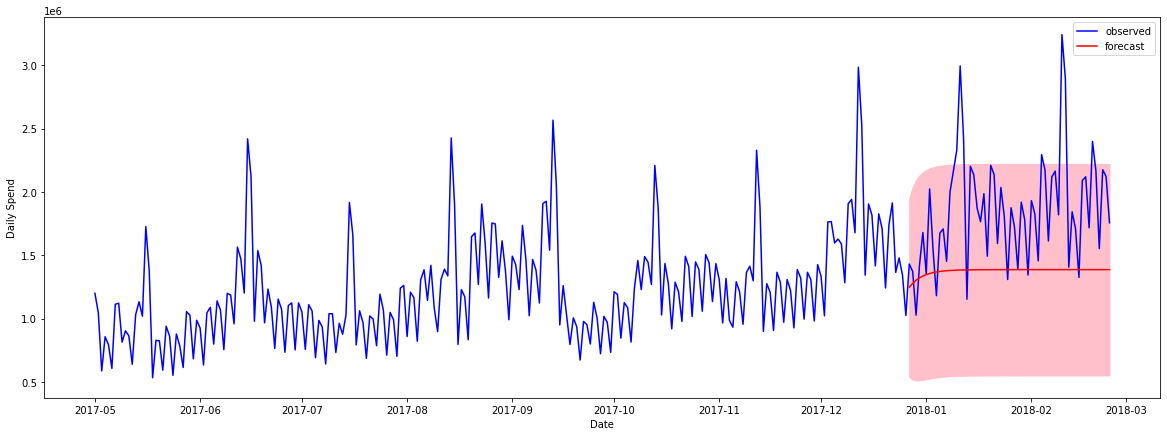

In [19]:
results = sarimax_forecast(spend, (1,0,1), 'c', -60, dynamic=True)

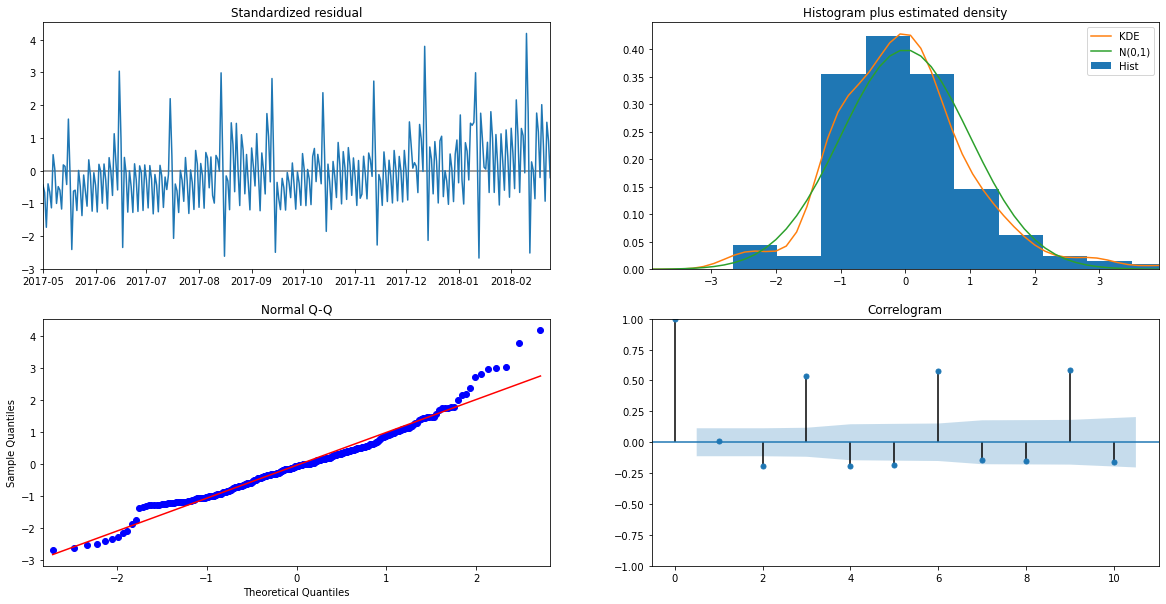

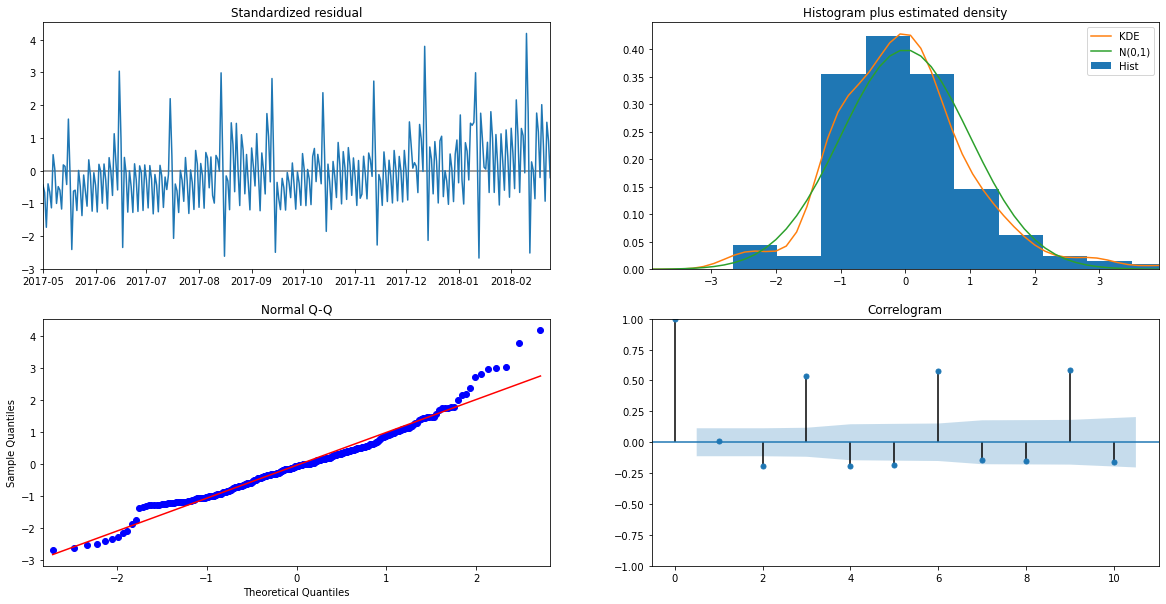

In [20]:
results.plot_diagnostics()

In [ ]:
model = sarimax_forecast(spend, (1,1,1), 'c', -60, dynamic=True, sorder=(1,1,1,12))

In [ ]:
model.plot_diagnostics()

In [ ]:
# lets use auto arima to find optimize for p,q,d, P, Q, D
model = pm.auto_arima(spend.GEMS_GEMS_SPENT, seasonal=True, trace=True, stepwise=True, 
                      information_criterion='aic', error_action='ignore', suppress_warnings=True,
                      d=1, m=12, start_p=1, start_q=1, start_P=1, start_Q=1, maxiter=50)

In [ ]:
sarimax_forecast(spend, (4,1,3), 'c', -60, dynamic=False, sorder=(0,0,2,12))

In [ ]:
results = sarimax_forecast(spend, (4,1,3), 'c', -60, dynamic=False, sorder=(0,0,2,12))

In [ ]:
results.plot_diagnostics()

In [17]:
def sarimax_forecast(df, order, trend, period, dynamic, sorder=(0,0,0)):
    # fit model and display diagnostics
    model = SARIMAX(df, order=order, sorder=sorder, trend=trend)
    results = model.fit()
    print(results.summary())

    # compute predictions, confidence intervals and MAE
    forecast = results.get_prediction(start=period, dynamic=dynamic)
    mean_forecast = forecast.predicted_mean
    confidence_intervals = forecast.conf_int()
    lower_limits = confidence_intervals.loc[:,'lower GEMS_GEMS_SPENT']
    upper_limits = confidence_intervals.loc[:,'upper GEMS_GEMS_SPENT']
    y_pred = pd.Series(mean_forecast).reset_index(drop=True)
    y_true = df[period:].iloc[:, 0].reset_index(drop=True)
    smape = round(smape_loss(y_pred, y_true) * 100, 2)
    print('Symmetric Mean Absolute Percentage Error: {}%'.format(smape))

    # plot predictions, confidence intervals and compute MAE
    plt.figure(figsize=(20, 7))
    plt.plot(df.index, df, color='b', label='observed')
    plt.plot(mean_forecast.index, mean_forecast.values, color='r', label='forecast')
    plt.fill_between(mean_forecast.index, lower_limits, upper_limits, color='pink')
    plt.xlabel('Date')
    plt.ylabel('Daily Spend')
    plt.legend()
    plt.show()
    
    return results
    

In [ ]:
results = sarimax_forecast(spend, (1,0,1), 'c', -60, dynamic=True)

In [ ]:
results.plot_diagnostics()

### Time Series Regression with SKTime

The model needs features, and all we have is a 1-dimentional time series. What features can we exctract?

* Lags of time series
* Window statistics:
    * Max/min value of series in a window
    * Average/median value in a window
    * Window variance
* Date and time features:
* Minute of an hour, hour of a day, day of the week, and so on
    * Is this day a holiday? Maybe there is a special event? Represent that as a boolean feature
    * Target encoding

In [28]:
# Creating a copy of the initial datagrame to make various transformations 
data = pd.DataFrame(spend.copy())
data.columns = ["y"]
data

,y
Time,
2017-05-01,1199436
2017-05-02,1045515
2017-05-03,586111
2017-05-04,856601
2017-05-05,793775
...,...
2018-02-20,2166449
2018-02-21,1552313
2018-02-22,2175548


### Lags of Time Series

Shifting the series  n  steps back, we get a feature column where the current value of time series is aligned with its value at time  t−n . If we make a 1 lag shift and train a model on that feature, the model will be able to forecast 1 step ahead from having observed the current state of the series. Increasing the lag, say, up to 6, will allow the model to make predictions 6 steps ahead; however it will use data observed 6 steps back. If something fundamentally changes the series during that unobserved period, the model will not catch these changes and will return forecasts with a large error. Therefore, during the initial lag selection, one has to find a balance between the optimal prediction quality and the length of the forecasting horizon.

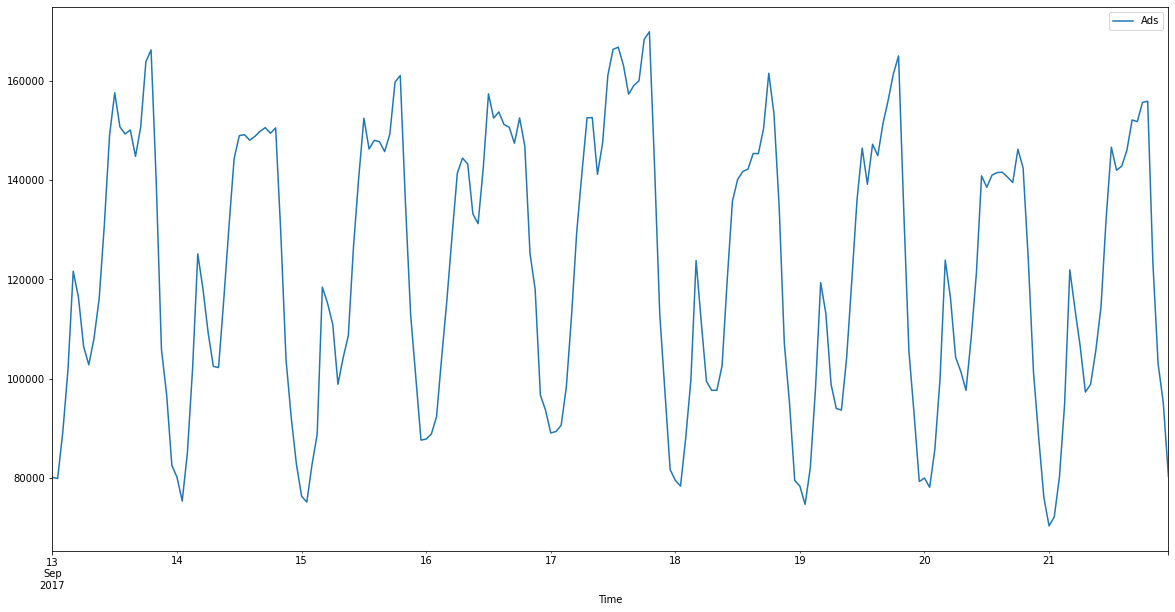

In [7]:
ads = pd.read_csv('/kaggle/input/adscsv/ads.csv', index_col=['Time'], parse_dates=['Time'])
ads.plot()

In [8]:
# Adding the lag of the target variable from 6 steps back up to 24
data = pd.DataFrame(ads.copy())
data.columns = ["y"]
for i in range(6, 25):
    data["lag_{}".format(i)] = data.y.shift(i)
data.tail()

,y,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
Time,,,,,,,,,,,,,,,,,,,,
2017-09-21 19:00:00,155890,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0,123945.0,142425.0
2017-09-21 20:00:00,123395,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0,123945.0
2017-09-21 21:00:00,103080,146020.0,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0
2017-09-21 22:00:00,95155,152120.0,146020.0,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0
2017-09-21 23:00:00,80285,151790.0,152120.0,146020.0,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0


Next, we'll add hour, day of week, and a boolean for is_weekend. To do so, we need to transform the current dataframe index into the datetime format and extract hour and weekday.

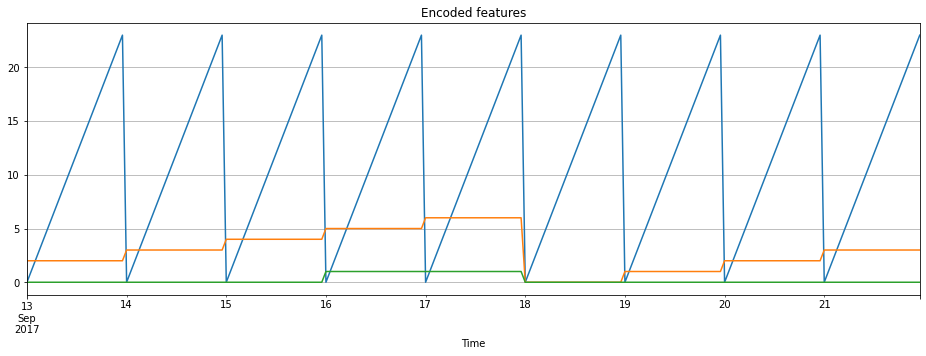

In [10]:
data.index = pd.to_datetime(data.index)
data["hour"] = data.index.hour
data["weekday"] = data.index.weekday
data['is_weekend'] = data.weekday.isin([5,6])*1
data.tail()

plt.figure(figsize=(16, 5))
plt.title("Encoded features")
data.hour.plot()
data.weekday.plot()
data.is_weekend.plot()
plt.grid(True);

I'd like to add another variant for encoding categorical variables: encoding by mean value. If it is undesirable to explode a dataset by using many dummy variables that can lead to the loss of information and if they cannot be used as real values because of the conflicts like "0 hours < 23 hours", then it's possible to encode a variable with slightly more interpretable values. The natural idea is to encode with the mean value of the target variable. In our example, every day of the week and every hour of the day can be encoded by the corresponding average number of ads watched during that day or hour. It's very important to make sure that the mean value is calculated over the training set only (or over the current cross-validation fold only) so that the model is not aware of the future.

In [12]:
def code_mean(data, cat_feature, real_feature):
    return dict(data.groupby(cat_feature)[real_feature].mean())

# calculate averages on train set only
test_size = 0.2
test_index = int(len(data.dropna())*(1-test_size))
data['weekday_average'] = list(map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday))
data["hour_average"] = list(map(code_mean(data[:test_index], 'hour', "y").get, data.hour))
data.drop(["hour", "weekday"], axis=1, inplace=True)
data

Since we now have different scales in our variables, thousands for the lag features and tens for categorical, we need to transform them into same scale for exploring feature importance and, later, regularization.

In [14]:
def plotModelResults(model, X_train, X_test, plot_intervals=False, plot_anomalies=False):
    prediction = model.predict(X_test)
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    tscv = TimeSeriesSplit(n_splits=3) 
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, cv=tscv, scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(y_test, prediction)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
    
def plotCoefficients(model):
    coefs = pd.DataFrame(model.feature_importances_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');
    

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


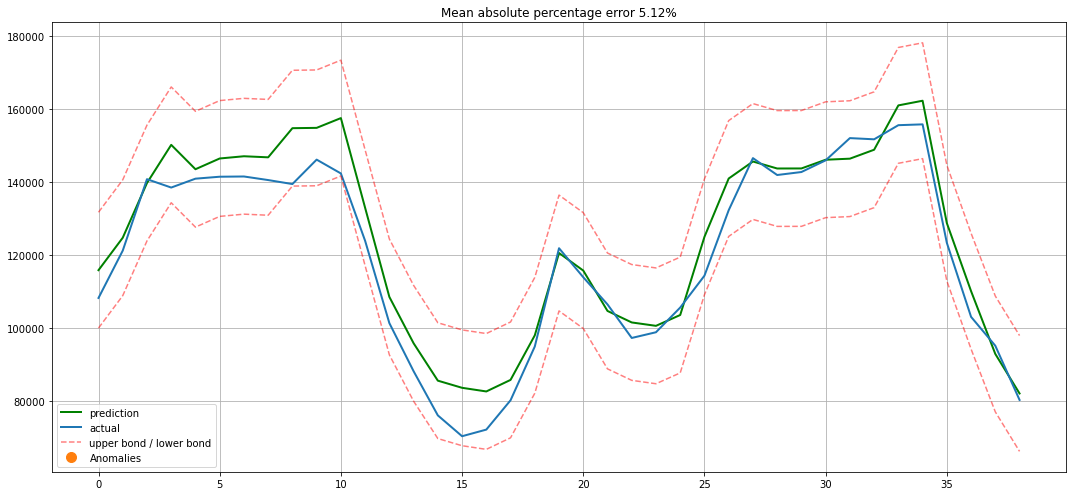

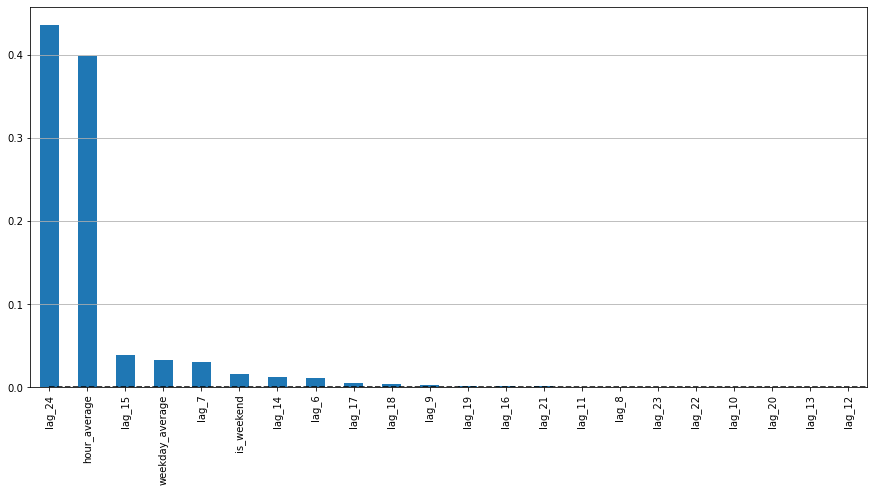

In [15]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
model = GradientBoostingRegressor()
model.fit(X_train_scaled, y_train)
plotModelResults(model, X_train_scaled, X_test_scaled, plot_intervals=True, plot_anomalies=True)
plotCoefficients(model)

Symmetric Mean Absolute Percentage Error: 16.51%


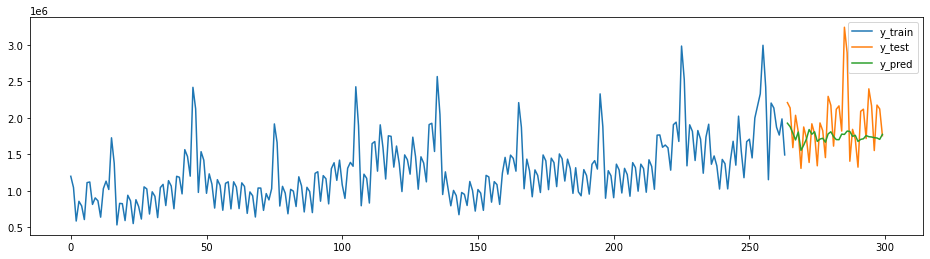

In [21]:
spend3 = spend.reset_index(drop=True)
y_train, y_test = temporal_train_test_split(spend3.GEMS_GEMS_SPENT, test_size=36)
horizon = np.arange(len(y_test)) + 1
regressor = GradientBoostingRegressor()
forecaster = ReducedRegressionForecaster(regressor=regressor, window_length=12, strategy="recursive")
forecaster.fit(y_train)
y_pred = forecaster.predict(horizon)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape = round(smape_loss(y_test, y_pred) * 100, 2)
print('Symmetric Mean Absolute Percentage Error: {}%'.format(smape))

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.54 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7551.721, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7426.287, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7454.733, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7549.725, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=7524.738, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=7409.576, Time=0.40 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=7387.655, Time=0.62 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=7386.312, Time=0.23 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=7466.486, Time=0.15 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=7387.715, Time=0.71 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=7438.979, Time=0.39 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=1.16 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=7399.906, Time=0.19 sec
 ARIMA(2,1,0)(1,0,1)[12] inte

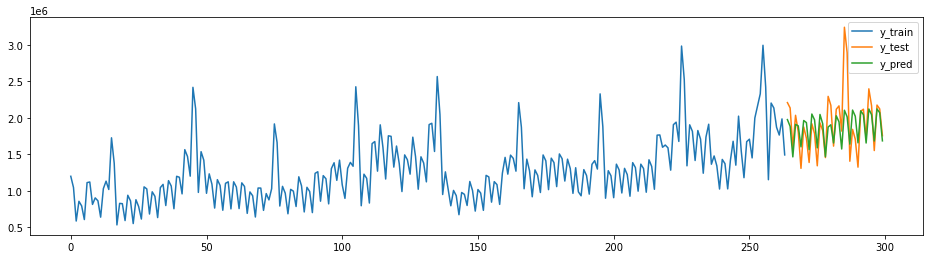

In [22]:
from sktime.forecasting.arima import AutoARIMA
forecaster = AutoARIMA(sp=12, suppress_warnings=True, trace=True, seasonal=True)
forecaster.fit(y_train)
y_pred, pred_ints = forecaster.predict(horizon, return_pred_int=True)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape = round(smape_loss(y_test, y_pred) * 100, 2)
print('Symmetric Mean Absolute Percentage Error: {}%'.format(smape))

In [ ]:
# sarimax_forecast(spend, (5,1,4), 'c', -60, dynamic=True, sorder=(0,0,2,12))

In [ ]:
# sarimax_forecast(spend, (5,1,4), 'c', -60, dynamic=False, sorder=(0,0,2,12))

In [1]:
%pip install sktime pmdarima

     |████████████████████████████████| 5.5 MB 4.4 MB/s eta 0:00:01
     |████████████████████████████████| 1.5 MB 7.0 MB/s eta 0:00:01
     |████████████████████████████████| 2.1 MB 7.9 MB/s eta 0:00:01
  Attempting uninstall: Cython
    Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
